In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import numpy as np
from import_casa import casa
from casa import caprice
from icecream import ic

In [3]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Microsoft JhengHei"
# plt.rcParams["font.family"] = "Heiti TC"

In [4]:
with open("../../../data/caprice/seq_shapley_data_cons.pkl", "rb") as fin:
    data = pickle.load(fin)

In [5]:
with open("../../../data/caprice/pos_list.txt", "r") as fin:
    pos_list = fin.readlines()
pos_list = [x.strip() for x in pos_list]

In [6]:
import csv
with open("../../../data/caprice/sentiment-constructicon.csv", "r", encoding="UTF-8") as fin:
    fin.readline()
    csvwriter = csv.reader(fin)
    constructions = [(x[0], float(x[1])) for x in csvwriter if x[1]]
len(constructions)

39

In [7]:
n_correct = sum(x[1] == x[3] for x in data)
print("Correctly classified: ", n_correct)
print("All instances: ", len(data))
print("Accuracy: ", n_correct/len(data))

Correctly classified:  101
All instances:  103
Accuracy:  0.9805825242718447


In [8]:
len(data[10][2]["raw_tokens"]), data[10][2]["pos_probs"].shape

(69, (69, 80))

In [106]:
import re
def find_construction(intxt, constructions):
    for cons, score in constructions:
        mat = re.search(cons, intxt)
        if mat:
            return cons, score
    return "", 0

In [107]:

def align_tokens(probe, tokens):
    start = -1
    end = -1
    cursor = 0
    # ic(len(probe))
    for tok_i, tok in enumerate(tokens):                
        tok = tok.strip()
        m = len(tok)
        # seg = probe[cursor:cursor+m]        
        if tok == probe[cursor:cursor+m]:
            if start == -1:
                start = tok_i                             
            else:
                end = tok_i            
            cursor += m
        else:
            if start != -1:
                cursor = 0
                start = -1
                end = -1        
        # ic(tok, seg, cursor, start, end)
        if cursor >= len(probe):
            return (start, end+1)        
    return (0, 0)

In [119]:
cons_scores = []
for data_x in data:
    if data_x[1] != data_x[3]:
        continue
    
    if data_x[1] == 1:
        polarity = -1
    elif data_x[1] == 2:
        polarity = 1
    else:
        continue
        
    txt = data_x[0]
    shap_data = data_x[2]
    cons, con_score = find_construction(txt, constructions)
    mat = re.search(cons, txt)
    raw_tokens = shap_data["raw_tokens"]
    tok_span = align_tokens(mat.group(), raw_tokens)
    try:
        assert "".join(raw_tokens[slice(*tok_span)]).strip() == mat.group()
    except:
        ic(mat.group())
        break
    tok2nd = shap_data["token_id_to_node_id_mapping"]
    group_values = shap_data["group_values"]
    shap_score = sum([group_values[int(x)] for x in set(tok2nd[slice(*tok_span)])])
    shap_score *= polarity
    cons_scores.append((cons, shap_score, data_x[1], con_score, data_x[0]))    

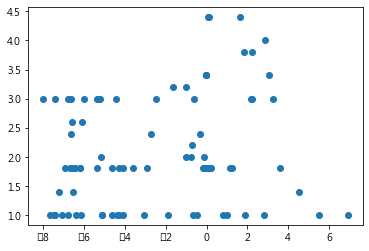

In [124]:
con_shaps = [x[1] for x in cons_scores]
con_score = [x[3] for x in cons_scores]
plt.scatter(con_shaps, con_score)

In [127]:
import pandas as pd
con_dfr = pd.DataFrame.from_records(cons_scores, columns=["cons", "shap_score", "seq_label", "con_score", "text"]).iloc[:, 1:4]
con_dfr.to_csv("../../../data/caprice/construction_shap.csv", index=False)

In [128]:
con_dfr

,shap_score,seq_label,con_score
0,-0.331501,2,2.4
1,-5.376208,1,3.0
2,-5.125409,1,1.0
3,1.815327,2,3.8
4,2.236522,2,3.8
...,...,...,...
80,-1.636020,1,3.2
81,-5.329955,1,3.0
82,-7.419636,1,3.0
83,-4.088854,1,1.0
